In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
from dictys.net import stat
import joblib
import pickle
from scipy.stats import median_abs_deviation, hypergeom
import math

In [2]:
from utils_custom import *

In [3]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files'
data_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(data_folder, 'dynamic.h5'))

### Expression dynamics

In [8]:
# get lcpm chars for these genes
lcpm_dcurve_pb, dtime_pb = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=2, num=20, dist=0.001, mode="expression")
# get lcpm chars for these genes
lcpm_dcurve_gc, dtime_gc = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=3, num=20, dist=0.001, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
display(lcpm_dcurve_pb.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
A1BG,4.593149,4.650957,4.704437,4.751729,4.790715,4.818866,4.833117,4.829891,4.805492,4.757084,4.684270,4.590654,4.484187,4.375423,4.274331,4.187617,4.117924,4.064713,4.025712,3.998128
A1BG-AS1,3.797306,3.824317,3.850778,3.875161,3.895562,3.909585,3.914240,3.905956,3.880899,3.835792,3.769302,3.683507,3.584414,3.480682,3.380956,3.291449,3.215037,3.151831,3.100350,3.058531
AAAS,4.328364,4.282979,4.239769,4.200465,4.166988,4.141471,4.126250,4.123756,4.136165,4.164722,4.208780,4.265043,4.327714,4.389931,4.445845,4.492074,4.527846,4.554199,4.572969,4.586066
AACS,4.725058,4.794780,4.861079,4.922605,4.978663,5.029168,5.074584,5.115827,5.154136,5.190839,5.227013,5.263108,5.298726,5.332771,5.363934,5.391211,5.414167,5.432894,5.447818,5.459499
AAGAB,5.647568,5.625459,5.602603,5.579724,5.557811,5.538133,5.522260,5.512042,5.509472,5.516321,5.533510,5.560407,5.594513,5.631969,5.668737,5.701759,5.729448,5.751509,5.768436,5.781056


### Regulation dynamics


In [20]:
pts, fsmooth = dictys_dynamic_object.linspace(0,2,20,0.001)
stat1_net = fsmooth(stat.net(dictys_dynamic_object)) #varname=w_in loads total effect network
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])

# Get episode specific GRN (transient state specific)

In [21]:
# pts is a dictys traj object
dnetbin = stat1_netbin.compute(pts)
dnetbin_episode = dnetbin[:, :, 15:20] #5 timepoints, excludes the last one

In [22]:
# compute the weighted network
dnet = stat1_net.compute(pts)
dnet_episode = dnet[:, :, 15:20]
display(dnet_episode)

array([[[ 1.12213267e-01,  1.14545211e-01,  1.15043076e-01,
          1.14412751e-01,  1.13211088e-01],
        [ 1.42495617e-02,  1.33962485e-02,  1.23362991e-02,
          1.11781593e-02,  9.99945769e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 4.59458801e-02,  3.56783468e-02,  2.68289006e-02,
          1.95319412e-02,  1.37481835e-02],
        [ 2.16470492e-04,  1.22199394e-04,  6.69729254e-05,
          3.58498996e-05,  1.88328071e-05]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.0000000

### Filter episodic GRN edges which are significantly non-zero across time points and are direction invariant

In [23]:
###### Get the tf and target names #####
# Create reverse mapping: index -> gene_name
ndict = dictys_dynamic_object.ndict
index_to_gene = {idx: name for name, idx in ndict.items()}
target_names = [index_to_gene[idx] for idx in range(dnetbin_episode.shape[1])]
# Get TF_gene_indices from TFs_to_keep_indices using nids[0]
tf_gene_indices = [dictys_dynamic_object.nids[0][tf_idx] for tf_idx in range(dnetbin_episode.shape[0])]
tf_names = [index_to_gene[idx] for idx in tf_gene_indices]
print(len(target_names))
print(len(tf_names))

11907
551


In [24]:
###### Create multi-index tuples (all combinations of TF-target pairs) ######
index_tuples = [(tf, target) for tf in tf_names for target in target_names]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = dnet_episode.shape
reshaped_data = dnet_episode.reshape(-1, n_times)
# Create DataFrame with multi-index
episode_beta_dcurve = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
# drop rows that are all 0
episode_beta_dcurve = episode_beta_dcurve[episode_beta_dcurve.sum(axis=1) != 0]
# the number of edges here remain the same between episodes, indicating that exact 0 are the edges that don't have atac-seq basis
display(episode_beta_dcurve.head())
display(episode_beta_dcurve.shape)

time_0    time_1    time_2    time_3    time_4
TF  Target                                                    
AHR A1BG      0.112213  0.114545  0.115043  0.114413  0.113211
    A1BG-AS1  0.014250  0.013396  0.012336  0.011178  0.009999
    AAGAB     0.001242  0.000842  0.000554  0.000355  0.000224
    AAK1      0.037811  0.033056  0.028391  0.024044  0.020142
    AAMDC     0.000032  0.000016  0.000008  0.000004  0.000002

(1612764, 5)

In [25]:
###### Filtering the global episodic GRN for retaining significantly non-zero and direction invariant edges ######
filtered_edges = filter_edges_by_significance_and_direction(
    episode_beta_dcurve,
    min_nonzero_timepoints=3,
    alpha=0.05,
    min_observations=3,
    check_direction_invariance=True,  # Enable direction invariance check
    n_processes=60,
    chunk_size=8000,
    save_intermediate=False,
    intermediate_path=output_folder
)
    
print(f"\nFinal shape: {filtered_edges.shape}")

# Save result
print("Saving results...")
filtered_edges.to_parquet(os.path.join(output_folder, "filtered_edges_significant_invariant_PB_ep4.parquet"))
print("Results saved!")

Processing 1,612,764 rows using 60 processes...
Chunk size: 8,000 rows
Direction invariance check: Enabled
Time columns: ['time_0', 'time_1', 'time_2', 'time_3', 'time_4']
Creating index chunks...
Created 202 chunks of indices


Processing chunks: 100%|██████████| 202/202 [00:51<00:00,  3.95it/s]


Processing completed in 53.76 seconds
Sorting results...
Creating result DataFrame...

Final shape: (971530, 6)
Saving results...
Results saved!


In [26]:
# load episode parquet file into pandas
#filtered_edges = pd.read_parquet('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/filtered_edges_significant_invariant_PB_ep4.parquet')
display(filtered_edges)

time_0    time_1    time_2    time_3    time_4  \
TF      Target                                                       
AHR     A1BG      0.112213  0.114545  0.115043  0.114413  0.113211   
        A1BG-AS1  0.014250  0.013396  0.012336  0.011178  0.009999   
        AAGAB     0.001242  0.000842  0.000554  0.000355  0.000224   
        AAK1      0.037811  0.033056  0.028391  0.024044  0.020142   
        AAMP      0.011236  0.013440  0.016492  0.020386  0.025070   
...                    ...       ...       ...       ...       ...   
ZSCAN30 ZSWIM6    0.098327  0.104033  0.107803  0.109891  0.110600   
        ZXDA     -0.000022 -0.000015 -0.000010 -0.000007 -0.000004   
        ZXDB     -0.000176 -0.000117 -0.000075 -0.000047 -0.000029   
        ZYG11B    0.005753  0.004723  0.003841  0.003109  0.002513   
        ZZEF1    -0.000818 -0.000547 -0.000355 -0.000225 -0.000140   

                       p_value  
TF      Target                  
AHR     A1BG      2.508622e-09  
        A1BG-AS1  8.686052e-05  
        AAGAB     2.424645e-02  
        AAK1      7.947750e-04  
        AAMP      2.182707e-03  
...                        ...  
ZSCAN30 ZSWIM6    1.231198e-06  
        ZXDA      2.057855e-02  
        ZXDB      2.869037e-02  
        ZYG11B    2.277938e-03  
        ZZEF1     2.655189e-02  

[971530 rows x 6 columns]

In [27]:
# drop edges with p_value > 0.01
filtered_edges_p001 = filtered_edges[filtered_edges['p_value'] < 0.001]
display(filtered_edges_p001.head())
display(filtered_edges_p001.shape)

time_0    time_1    time_2    time_3    time_4       p_value
TF  Target                                                                  
AHR A1BG      0.112213  0.114545  0.115043  0.114413  0.113211  2.508622e-09
    A1BG-AS1  0.014250  0.013396  0.012336  0.011178  0.009999  8.686052e-05
    AAK1      0.037811  0.033056  0.028391  0.024044  0.020142  7.947750e-04
    AARS2     0.010985  0.010598  0.010235  0.009942  0.009732  1.364040e-06
    ABCA7    -0.008145 -0.009586 -0.010955 -0.012229 -0.013401  3.084919e-04

(439971, 6)

## Get TF forces for the episode

In [28]:
# get tf lcpm values for tfs kept in filtered_edges_p001
tf_lcpm_values = lcpm_dcurve_pb.loc[filtered_edges_p001.index.get_level_values(0).unique()]
display(tf_lcpm_values.shape)
# slice the df to only contain that episode (5 columns)
tf_lcpm_episode = tf_lcpm_values.iloc[:, 15:20]
# Adaptive column renaming to match beta curves
beta_time_cols = [col for col in filtered_edges_p001.columns if col.startswith('time_')]
n_time_cols = len(beta_time_cols)

# Rename TF expression columns to match beta curves format
tf_lcpm_episode.columns = beta_time_cols[:n_time_cols]
display(tf_lcpm_episode)

(504, 20)

,time_0,time_1,time_2,time_3,time_4
TF,,,,,
AHR,5.911886,5.810703,5.725121,5.652911,5.591544
ARID3A,7.523344,7.586238,7.630942,7.661256,7.680930
ARID3B,7.152158,7.195600,7.225796,7.245668,7.257983
ARID5A,5.396882,5.295436,5.211596,5.142818,5.086137
ARID5B,8.955334,8.894727,8.847911,8.812580,8.786124
...,...,...,...,...,...
ZNF891,2.808549,2.746804,2.695011,2.651377,2.614047
ZNF90,4.929965,4.920138,4.913339,4.908388,4.904378
ZNF98,1.396270,1.381066,1.366761,1.353645,1.341798


In [29]:
# Prepare beta curves (only time columns)
beta_curves_for_force = filtered_edges_p001.drop('p_value', axis=1)

print("Starting parallel force calculation...")
print(f"Input beta curves shape: {beta_curves_for_force.shape}")
print(f"TF expression shape: {tf_lcpm_episode.shape}")

# Calculate forces in parallel
force_curves = calculate_force_curves_parallel(
    beta_curves=beta_curves_for_force,
    tf_expression=tf_lcpm_episode,
    n_processes=20,  # Adjust based on your system
    chunk_size=30000,  # Adjust based on available memory
    epsilon=1e-10,
    save_intermediate=False
)

print(f"Force calculation completed!")
print(f"Output shape: {force_curves.shape}")
# Display sample results
display(force_curves.head())

Starting parallel force calculation...
Input beta curves shape: (439971, 5)
TF expression shape: (504, 5)
Processing 439,971 edges using 20 processes...
Chunk size: 30,000 rows
Time columns: ['time_0', 'time_1', 'time_2', 'time_3', 'time_4']
Beta curves shape: (439971, 5)
TF expression shape: (504, 5)
Created 14 chunks
Chunk sizes: [31427, 31427, 31427, 31427, 31427]...


Processing chunks: 100%|██████████| 14/14 [00:01<00:00, 11.55it/s]


Processing completed in 2.25 seconds
Combining results...
Final shape: (439971, 5)
Force calculation completed!
Output shape: (439971, 5)


time_0    time_1    time_2    time_3    time_4
TF  Target                                                    
AHR A1BG      0.912903  0.924080  0.928121  0.927620  0.924619
    A1BG-AS1  0.372556  0.363873  0.351949  0.337821  0.322296
    AAK1      0.569182  0.538654  0.505466  0.471142  0.436854
    AARS2     0.332744  0.328672  0.324540  0.321051  0.318524
    ABCA7    -0.292210 -0.314647 -0.334254 -0.351266 -0.366004

#### Get the average force over the episode

In [30]:
# Calculate average force over the 5 time points
avg_force = force_curves.mean(axis=1)
print(f"Average force shape: {avg_force.shape}")
# Convert to DataFrame with proper column name
avg_force_df = avg_force.to_frame(name='avg_force')
display(avg_force_df.head())

Average force shape: (439971,)


avg_force
TF  Target             
AHR A1BG       0.923469
    A1BG-AS1   0.349699
    AAK1       0.504260
    AARS2      0.325106
    ABCA7     -0.331676

Average force distribution statistics:
Total edges: 439,971
Mean: 0.052007
Median: 0.129896
Std: 0.419942
Min: -3.274362
Max: 2.785682

Percentile analysis:
50th percentile: 0.312520 (219,986 edges = 50.00%)
75th percentile: 0.457763 (109,993 edges = 25.00%)
90th percentile: 0.643997 (43,998 edges = 10.00%)
95th percentile: 0.786395 (21,999 edges = 5.00%)
97th percentile: 0.892119 (13,200 edges = 3.00%)
98th percentile: 0.978395 (8,800 edges = 2.00%)
99th percentile: 1.123213 (4,400 edges = 1.00%)


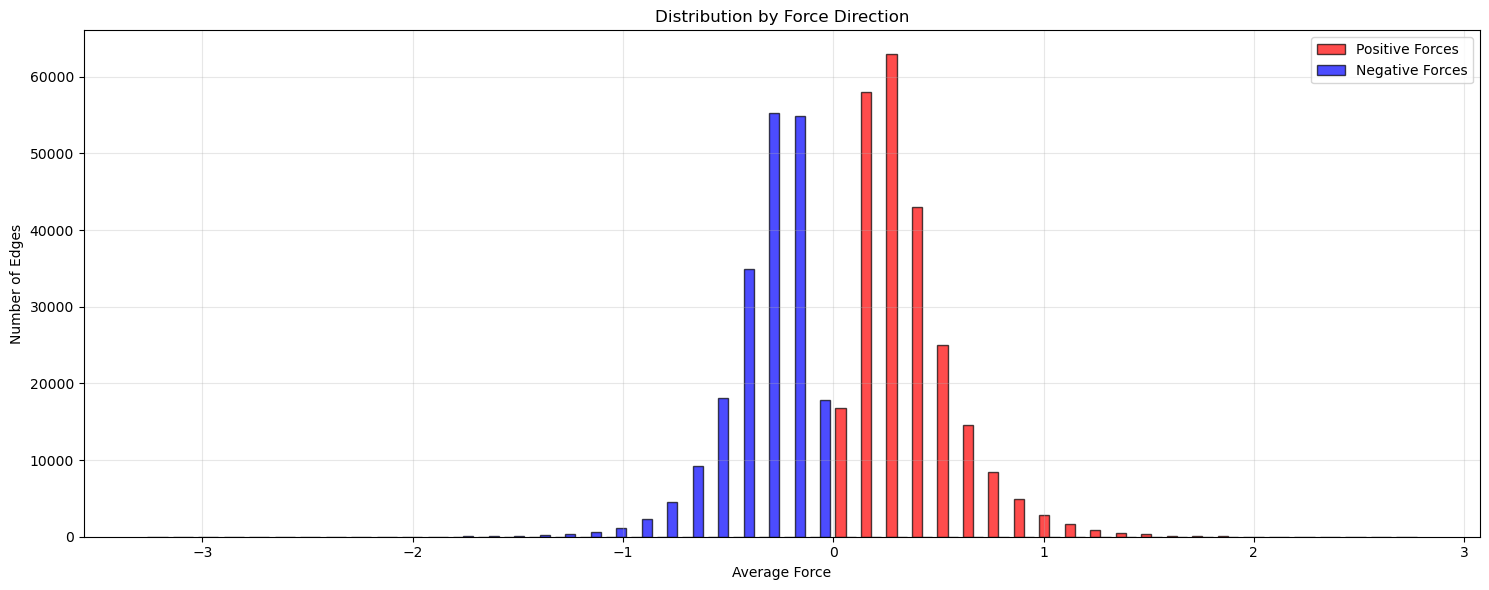

In [31]:
# Get summary statistics for average forces
print("Average force distribution statistics:")
print(f"Total edges: {len(avg_force):,}")
print(f"Mean: {avg_force.mean():.6f}")
print(f"Median: {avg_force.median():.6f}")
print(f"Std: {avg_force.std():.6f}")
print(f"Min: {avg_force.min():.6f}")
print(f"Max: {avg_force.max():.6f}")

# Calculate percentiles
percentiles = [50, 75, 90, 95, 97, 98, 99]
print(f"\nPercentile analysis:")
for p in percentiles:
    threshold = np.percentile(np.abs(avg_force), p)
    count_above = sum(np.abs(avg_force) >= threshold)
    percentage = (count_above / len(avg_force)) * 100
    print(f"{p}th percentile: {threshold:.6f} ({count_above:,} edges = {percentage:.2f}%)")

# Plot distribution
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

# Separate positive and negative forces
positive_forces = avg_force[avg_force > 0]
negative_forces = avg_force[avg_force < 0]

axes.hist([positive_forces, negative_forces], bins=50, alpha=0.7, 
              color=['red', 'blue'], label=['Positive Forces', 'Negative Forces'], edgecolor='black')
axes.set_xlabel('Average Force')
axes.set_ylabel('Number of Edges')
axes.set_title('Distribution by Force Direction')
axes.legend()
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Select the top 1% of edges to build the episodic GRN

In [32]:
# Calculate the (100-k)th percentile threshold using absolute values
threshold = np.percentile(np.abs(avg_force), 98)
# Create a boolean mask for edges above the threshold
top_percent_mask = np.abs(avg_force) >= threshold
# Create separate dataframe with top k% edges
top_percent_df = avg_force[top_percent_mask].copy()
episodic_grn_edges = top_percent_df.to_frame(name='avg_force')
display(episodic_grn_edges)
# display the unique tf and target numbers
display(len(episodic_grn_edges.index.get_level_values(0).unique()))
display(len(episodic_grn_edges.index.get_level_values(1).unique()))

avg_force
TF      Target            
AHR     ABHD18   -0.998576
        AICDA     1.032258
        ATP6V1F  -1.107424
        BPTF      1.223905
        BRIP1     1.104481
...                    ...
ZNF860  ETS1     -1.122049
ZNF891  MBD2      1.549906
ZSCAN30 AHR       1.138874
        SHCBP1   -1.070869
        USF1      1.059760

[8800 rows x 1 columns]

269

4731

## Get the TFs acting on LF genes

In [33]:
# load LF files 
z11_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z11_GC_PB.txt'
z3_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z3_GC_PB.txt'
# load into a list of gene names 
z11 = pd.read_csv(z11_file, sep='\t', header=0)
z3 = pd.read_csv(z3_file, sep='\t', header=0)
# remove HLA- genes
z11 = z11[~z11['names'].str.contains('HLA-')]
z3 = z3[~z3['names'].str.contains('HLA-')]

In [34]:
# get the gene names 
z11_genes = z11['names'].tolist()
z3_genes = z3['names'].tolist()
# create a list of all lf genes 
lf_genes = list(set(z11_genes + z3_genes))
lf_in_object = check_if_gene_in_ndict(dictys_dynamic_object, lf_genes, return_index=True)
print(f"Found {len(lf_in_object['present'])} genes")
print(f"Missing {len(lf_in_object['missing'])} genes")
print("Indices:", lf_in_object['indices'])

Found 57 genes
Missing 0 genes
Indices: {'CEP128': 1733, 'RNF213': 8355, 'CD79A': 1587, 'ARFGAP3': 560, 'B2M': 872, 'DEK': 2479, 'CD74': 1586, 'FNDC3A': 3516, 'PDE4D': 7027, 'EEA1': 2862, 'TRAM2': 10473, 'ARNTL2': 665, 'SLAMF7': 8987, 'MAPK1': 5543, 'TXNDC5': 10727, 'MAN1A1': 5488, 'JCHAIN': 4730, 'UBAC2': 10759, 'BTG2': 1106, 'HM13': 4210, 'IGHM': 4421, 'MZB1': 6199, 'HSP90B1': 4304, 'CDK6': 1665, 'ANKRD28': 429, 'TRAM1': 10472, 'SEL1L3': 8763, 'IRF4': 4652, 'PAX5': 6943, 'RUNX2': 8586, 'GAB1': 3613, 'TBC1D4': 9887, 'MED23': 5675, 'ELL2': 2979, 'SLC25A13': 9042, 'PRDM1': 7604, 'FNDC3B': 3517, 'LMAN1': 5269, 'TXNDC11': 10722, 'SLA': 8982, 'PIM2': 7239, 'PIKFYVE': 7235, 'CIITA': 1884, 'CD52': 1574, 'CPEB4': 2131, 'SSR1': 9582, 'TNFAIP8': 10337, 'CTSH': 2270, 'AFF3': 230, 'SUB1': 9706, 'GLCCI1': 3767, 'CCSER2': 1534, 'CD99': 1598, 'XBP1': 11200, 'TIAM1': 10070, 'IQGAP2': 4638, 'PPIB': 7507}


#### Get the enrichment (over representation) of LF genes in TF regulons

In [35]:
# add a boolean column indicating if the target is a lf gene in the episodic grn df
episodic_grn_edges['is_in_lf'] = episodic_grn_edges.index.get_level_values(1).isin(lf_genes)
# get the number of genes in the episodic grn edges
target_genes_in_episodic_grn = episodic_grn_edges.index.get_level_values(1).unique()
display("Number of targets in episodic grn: ", len(target_genes_in_episodic_grn))
# get the number of lf_genes in the episodic grn edges
lf_in_episodic_grn = episodic_grn_edges[episodic_grn_edges['is_in_lf']]
display(lf_in_episodic_grn.head())
# get the unique LF genes active in the lf_in_episodic_grn df
lf_genes_active_in_episode = lf_in_episodic_grn.index.get_level_values(1).unique()
display("Number of LF genes active in episode: ", len(lf_genes_active_in_episode))
tfs_acting_on_lf = lf_in_episodic_grn.index.get_level_values(0).unique()
display("TFs acting on LF genes: ", tfs_acting_on_lf, len(tfs_acting_on_lf))
# take the tfs in the lf_in_episodic_grn df and subset the episodic_grn_edges df to only include these tfs
episodic_grn_edges_subset = episodic_grn_edges[episodic_grn_edges.index.get_level_values(0).isin(lf_in_episodic_grn.index.get_level_values(0))]
display(episodic_grn_edges_subset.head())
display(episodic_grn_edges_subset.shape)

'Number of targets in episodic grn: '

4731

avg_force  is_in_lf
TF     Target                      
ARID3B B2M      -1.066914      True
       MAN1A1    1.485519      True
ARID5A IGHM     -1.339538      True
ARNTL  HSP90B1  -1.157533      True
ATF3   HSP90B1  -1.009362      True

'Number of LF genes active in episode: '

44

'TFs acting on LF genes: '

Index(['ARID3B', 'ARID5A', 'ARNTL', 'ATF3', 'BPTF', 'CREB3L2', 'CTCF', 'CUX1',
       'E2F4', 'ELF2', 'ETS1', 'FOXO1', 'FOXO4', 'GABPA', 'HES1', 'IKZF3',
       'IRF2', 'IRF4', 'IRF7', 'IRF8', 'IRF9', 'KLF11', 'KLF2', 'KLF7',
       'LIN54', 'MBD2', 'MECP2', 'MEF2A', 'MEF2C', 'MTF2', 'MYB', 'MYC',
       'NFATC3', 'NRF1', 'POU2F2', 'RELB', 'RUNX1', 'RUNX3', 'STAT2', 'STAT3',
       'STAT5B', 'TCF7', 'TCF7L2', 'TCFL5', 'TEAD2', 'TFAP2E', 'TFEC',
       'ZNF100', 'ZNF341', 'ZNF425', 'ZNF519', 'ZNF786'],
      dtype='object', name='TF')

52

avg_force  is_in_lf
TF     Target                       
ARID3B ACSL5      1.058115     False
       ALCAM      1.130663     False
       ARHGAP15   1.163182     False
       ARHGAP42   1.090699     False
       ATF7IP     1.092032     False

(6348, 2)

In [36]:
episodic_enrichment_df = calculate_tf_episodic_enrichment(episodic_grn_edges_subset, 
                                       len(lf_genes_active_in_episode), 
                                       len(target_genes_in_episodic_grn))
# sort the episodic_enrichment_df_p005 by enrichment_score in descending order
episodic_enrichment_df_sorted = episodic_enrichment_df.sort_values(by='enrichment_score', ascending=False)
# filter the episodic_enrichment_df to only include tfs with a p_value < threshold
episodic_enrichment_df_p005 = episodic_enrichment_df_sorted[episodic_enrichment_df_sorted['p_value'] < 0.05]
display(episodic_enrichment_df_p005)

,TF,p_value,enrichment_score,genes_in_lf,genes_dwnstrm,weights
35,RELB,0.009300,107.522727,"(RNF213,)",(),"(-1.150329589562594,)"
34,POU2F2,0.018516,53.761364,"(MAN1A1,)","(MEF2B,)","(-1.0463344974408848,)"
44,TEAD2,0.000831,43.009091,"(GLCCI1, PAX5)","(CEBPG, ELK1, KLF2)","(0.998802159789719, 1.1944264185736515)"
51,ZNF786,0.027648,35.840909,"(GLCCI1,)","(MBD2, ZNF2)","(-1.0435375114044931,)"
39,STAT3,0.036697,26.880682,"(B2M,)","(IQGAP1, TMEM154, ZNF222)","(-1.082706375145945,)"
50,ZNF519,0.036697,26.880682,"(CD79A,)","(CIC, E2F4, HES1)","(-1.1405279087369613,)"
40,STAT5B,0.036697,26.880682,"(IGHM,)","(GTF2E2, KIF2C, RPS8)","(-1.062797628872986,)"
17,IRF4,0.003629,21.504545,"(GAB1, GLCCI1)","(ELF4, INTS10, KDM5A, LNPEP, NR4A3, RASGRP3, S...","(1.0146342019222245, 0.9843635240601986)"
19,IRF8,0.001497,12.902727,"(CEP128, PRDM1, RNF213)","(CD226, CHD1, COBLL1, DNAJA1, DUT, DYNLL1, ELK...","(-1.1567045000695728, 1.0402385323939183, -1.2..."
20,IRF9,0.001497,12.902727,"(B2M, CEP128, RNF213)","(AFTPH, AGFG1, ATAD1, BACH2, CASP10, CMSS1, DN...","(1.0387004517950367, -1.2953418033174096, -1.0..."


In [37]:
# save the episodic_enrichment_df_p005_sorted df to a csv file
episodic_enrichment_df_sorted.to_csv(os.path.join(output_folder, 'enrichment_ep4_pb.csv'), index=False)